In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot  as plt

## Открытие датасета

In [3]:
raw_df = pd.read_csv('C:/Users/lyuba/Desktop/Datasets/project1/project1_data.csv')
pd.set_option('display.max_columns', None)
raw_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Знакомство с данными и их подготовка к дальнейшему анализу

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Проверка на повторяющиеся значения по ключевому столбцу ID 

raw_df.duplicated('ID').any()

False

### Выводы: 
1. Столбец Income содержит 24 пропущенных значения, это необходимо иметь в виду при дальнейшем анализе
2. Для большей наглядности и информативности желательно заменить значения в столбце Year_Birth со значения года на звачение возраста, а значения столбца Dt_Customer со значения даты первой поупки на значение количества дней в качестве покупателя.
3. Стоит добавить столбец с информацией об общем колицестве затрат на все категории товаров (Mnt_Total)
4. Стоит добавить столбец о том, сколько рекламных компаний было "одобрено" каждым покупателем (Accepted_Total)
5. Стоит добавить столбец, сождержащий информацию об общем количестве покупок у каждого покупателя (Purchases_Total)
6. В таблице нет дубликатов по ID покупателей, каждый человек встречается один раз


*** Типы данных в столбцах AcceptedCmp3-Complain и Response, согласно описанию данных, соответствуют boolean-значениям, но сейчас это целочисленные значения (int64). В отдельной ячейке будет прописан код для проведения данного преобразования, если таковое потребуется

In [6]:
new_var = pd.DataFrame({'ID': raw_df['ID'],
                   'Age': (pd.to_datetime('now').year - raw_df['Year_Birth']), # подсчет возраста покупателей
                   'Days_as_cus': ((pd.to_datetime('now') - pd.to_datetime(raw_df['Dt_Customer'])) // pd.Timedelta(1, 'd')), # Подсчет количества дней с первого дня в качестве покупателя
                   'Mnt_Total': raw_df.loc[:,['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1), # Подсчет общих затрат на все категории товаров 
                   'Accepted_Total': raw_df.loc[:,['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1), # подсчет общего числа одобрения рекламных компаний
                   'Purchases_Total': (raw_df['NumWebPurchases'] + raw_df['NumStorePurchases']), # подсчет общего числа совершенных покупок 
                   'Children_Total': raw_df.loc[:, ['Kidhome', 'Teenhome']].sum(axis=1) # подсчет общего количества детей в семье
                   })

df = new_var.merge(raw_df
                   .drop(['Year_Birth', 'Dt_Customer'], axis=1) # Удаление ненужных столбцов 
                   .dropna(), # Удаление строк с пропущенными значениями хоть в одном из столбцов
                   on='ID')
df.head()

,ID,Age,Days_as_cus,Mnt_Total,Accepted_Total,Purchases_Total,Children_Total,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,68,4576,1529,1,12,0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,71,4026,21,0,3,2,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,60,4225,734,0,18,0,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,41,4052,48,0,6,1,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,44,4074,407,0,11,1,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [ ]:
# ЗАПУСКАТЬ ЯЧЕЙКУ ПРИНЕОБХОДИМОСТИ!!!
# Приведение необходимых столбцов к формату boolean

#for column in df.columns[20:26]:
#    df[column] = df[column].astype(bool)

#df['Response'] = df['Response'].astype(bool)
#df.info()

## Проверка на наличие ошибок в данных

In [7]:
# Общие траты не должны быть равны нулю (иначе покупатель ничего не покупал)

df[df['Mnt_Total'] == 0]

,ID,Age,Days_as_cus,Mnt_Total,Accepted_Total,Purchases_Total,Children_Total,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


In [8]:
# Общее количество покупок также не должно быть равно нулю

df[df['Purchases_Total'] == 0]

,ID,Age,Days_as_cus,Mnt_Total,Accepted_Total,Purchases_Total,Children_Total,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
20,5376,46,4452,1729,0,0,1,Graduation,Married,2447.0,1,0,42,1,1,1725,1,1,1,15,0,28,0,1,0,0,0,0,0,0,3,11,0
153,8475,52,4033,1607,0,0,1,PhD,Married,157243.0,0,1,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,3,11,0
642,5555,50,4055,5,0,0,0,Graduation,Divorced,153924.0,0,0,81,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,3,11,0
968,3955,60,3920,5,0,0,0,Graduation,Divorced,4861.0,0,0,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,3,11,0
1029,10749,34,4562,176,0,0,0,Graduation,Single,8028.0,0,0,62,73,18,66,7,12,2,15,0,1,0,19,0,0,0,0,0,0,3,11,0
1232,6862,54,3955,7,0,0,0,Graduation,Divorced,1730.0,0,0,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,3,11,0
1507,11110,52,4355,4,0,0,1,Graduation,Single,3502.0,1,0,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,3,11,0
1636,4931,48,4339,1729,0,0,0,Graduation,Together,157146.0,0,0,13,1,0,1725,2,1,1,0,0,28,0,1,0,0,0,0,0,0,3,11,0
1829,9931,62,3919,8,0,0,2,PhD,Married,4023.0,1,1,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,3,11,0
2109,11181,76,4217,7,0,0,0,PhD,Married,156924.0,0,0,85,2,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,3,11,0


### Вывод: 
В идеале я бы обратилась с вопросом к дата-инженеру, чтобы уточнить, каким образом могло получиться так, что у 10 покупателей общее количество покупок оказалось равно нулю. Имеет ли место такой результат или при сборе/изменении данных произошла ошибка.

На данный момент я не буду удалять эти наблюдения, чтобы не терять данные.

UPD: при удалении выбросов по другим столбцам данные наблюдения будут удалены из таблицы.

## Проверка на наличие выбросов 

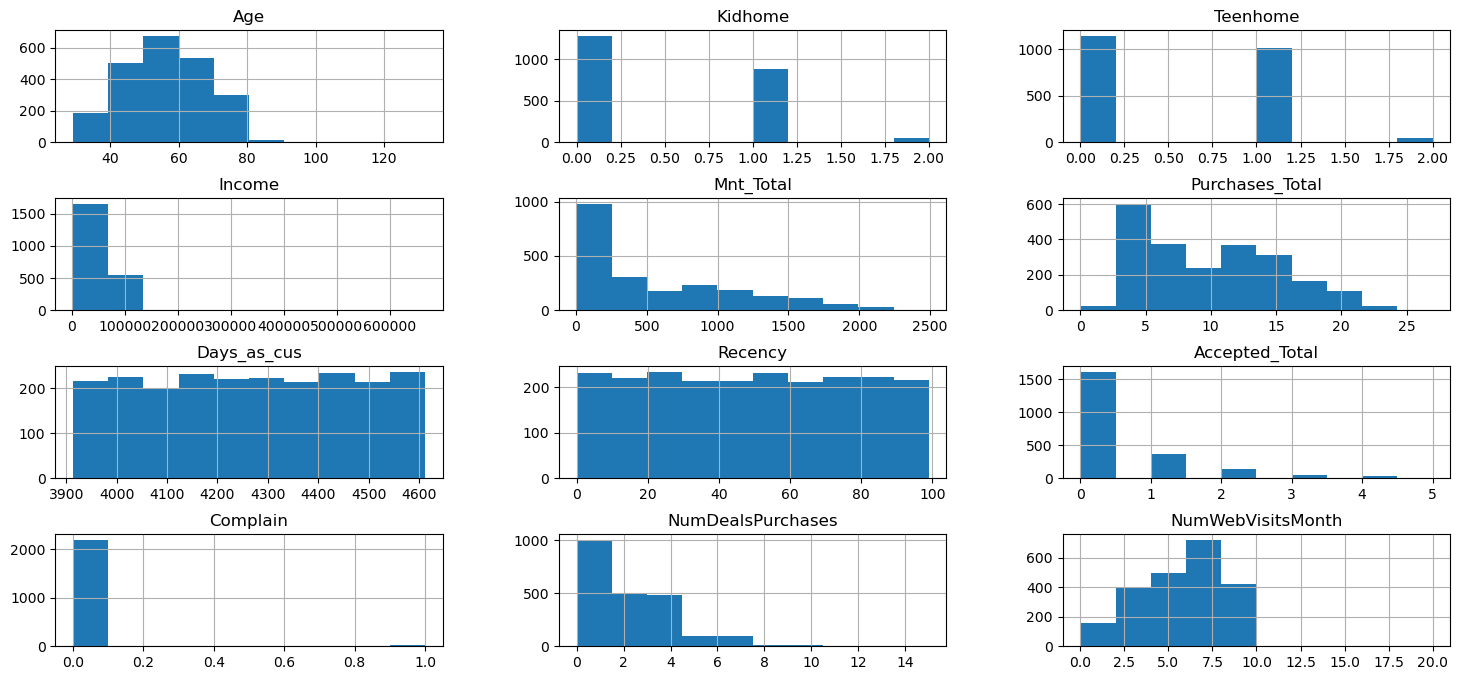

In [9]:
df.hist(column = ['Age', 'Kidhome', 'Teenhome', 'Income', 'Mnt_Total', 'Purchases_Total', 'Days_as_cus', 'Recency', 'Accepted_Total', 'Complain', 'NumDealsPurchases', 'NumWebVisitsMonth'], figsize=(18,8))
plt.subplots_adjust(hspace=0.5)


<Axes: >

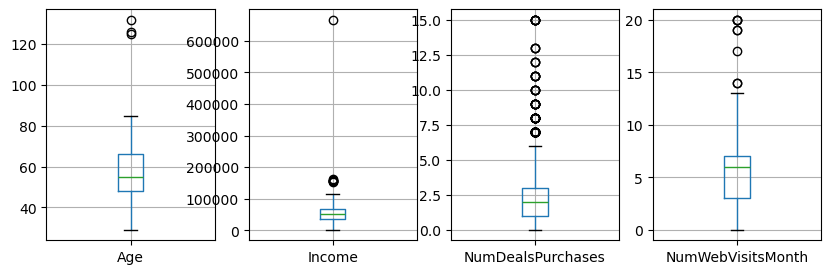

In [10]:
fig, ax = plt.subplots(1,4, figsize=(10,3))

df.boxplot(column=['Age'], ax=ax[0])
df.boxplot(column=['Income'], ax=ax[1])
df.boxplot(column=['NumDealsPurchases'], ax=ax[2])
df.boxplot(column=['NumWebVisitsMonth'], ax=ax[3])

### Выводы:
1. Переменные Age, Income, NumDealsPurchases и NumWebVisitsMonth имеют существенные выбросы. Для большей достоверности результатов дальнейших вычислений необходимо удалить их из рабочей табилцы 

In [11]:
# Создаем отдельную таблицу, содержащую выбросы, чтобы при необходимости можно было включить данные обратно в рабочую таблицу

df_outliers = df
clear_df = df_outliers[0:0]

for column in df_outliers.loc[:, ['Age', 'Income', 'NumDealsPurchases', 'NumWebVisitsMonth']]:
    Q1 = df_outliers[column].quantile(0.25)
    Q3 = df_outliers[column].quantile(0.75)
    IQR = Q3 - Q1    
    clear_df = pd.concat([clear_df, df_outliers[df_outliers[column] > (Q3 + 1.5*IQR)]])
    

df_outliers = clear_df
df_outliers.head()

,ID,Age,Days_as_cus,Mnt_Total,Accepted_Total,Purchases_Total,Children_Total,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
181,7829,125,4189,40,0,4,1,2n Cycle,Divorced,36640.0,1,0,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,1,3,11,0
228,11004,132,3956,20,0,3,1,2n Cycle,Single,60182.0,0,1,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,3,11,0
326,1150,126,4189,1629,1,8,0,PhD,Together,83532.0,0,0,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,3,11,0
153,8475,52,4033,1607,0,0,1,PhD,Married,157243.0,0,1,98,20,2,1582,1,2,1,15,0,22,0,0,0,0,0,0,0,0,3,11,0
604,1503,49,4304,105,0,1,2,PhD,Together,162397.0,1,1,31,85,1,16,2,1,2,0,0,0,1,1,0,0,0,0,0,0,3,11,0


In [12]:
# исключаем из рабочей таблицы наблюдения с выбросами

for column in df.loc[:, ['Age', 'Income', 'NumDealsPurchases', 'NumWebVisitsMonth']]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    new_df = df[df[column] <= (Q3 + 1.5*IQR)]
    df = new_df

df

,ID,Age,Days_as_cus,Mnt_Total,Accepted_Total,Purchases_Total,Children_Total,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,68,4576,1529,1,12,0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,71,4026,21,0,3,2,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,60,4225,734,0,18,0,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,41,4052,48,0,6,1,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,44,4074,407,0,11,1,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,8372,51,4276,21,0,3,1,Graduation,Married,34421.0,1,0,81,3,3,7,6,2,9,1,1,0,2,7,0,0,0,0,0,0,3,11,0
2211,10870,58,4294,1094,0,13,1,Graduation,Married,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2213,7270,44,4068,1217,1,15,0,Graduation,Divorced,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2214,8235,69,4069,782,0,16,1,Master,Together,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


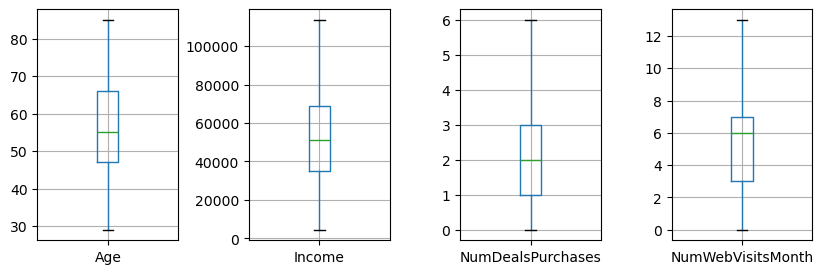

In [13]:
# проверка отсутствия выбросов

fig, ax = plt.subplots(1,4, figsize=(10,3))

df.boxplot(column=['Age'], ax=ax[0])
df.boxplot(column=['Income'], ax=ax[1])
df.boxplot(column=['NumDealsPurchases'], ax=ax[2])
df.boxplot(column=['NumWebVisitsMonth'], ax=ax[3])
plt.subplots_adjust(wspace=0.5)

## Описательный анализ социально-демографических данных выборки

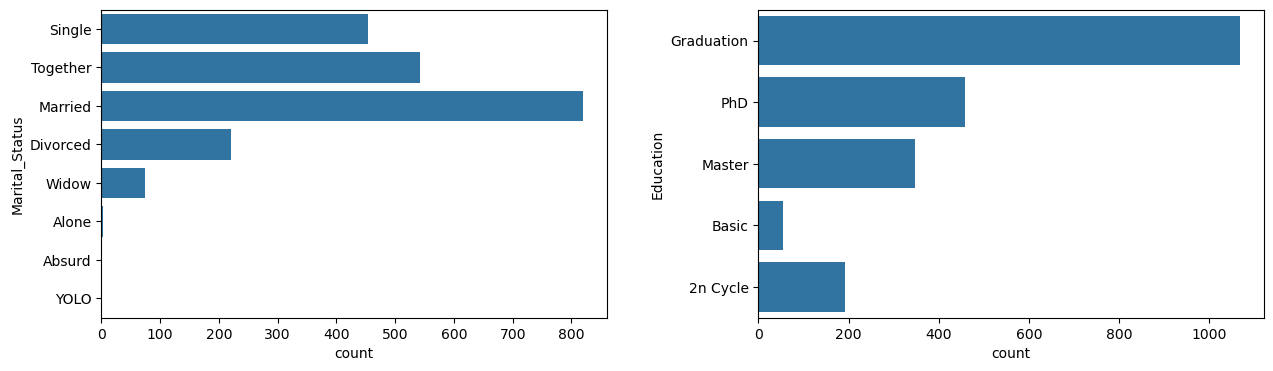

In [14]:
# Построение столбчатых диаграмм по переменным семейного статуса и уровня образования

fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.countplot(df['Marital_Status'], ax=ax[0])
sns.countplot(df['Education'], ax=ax[1])

plt.subplots_adjust(wspace=0.3)
plt.show()

### Выводы:
1. В графе семейного статуса некоторые покупатели проставили собственные статусы, которые могут быть включены в категорию "Одинокий".
2. В графе уровня образования некоторые покупатели указали "Master", а некоторые "2n Cycle". По сути это одно и то же, соответственно можно привести оба варианта к "Master"



In [15]:
# Замена нестандартных семейных статусов на "Single" и статуса образования '2n Cycle' на 'Master'

df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
df['Education'] = df['Education'].replace('2n Cycle', 'Master')

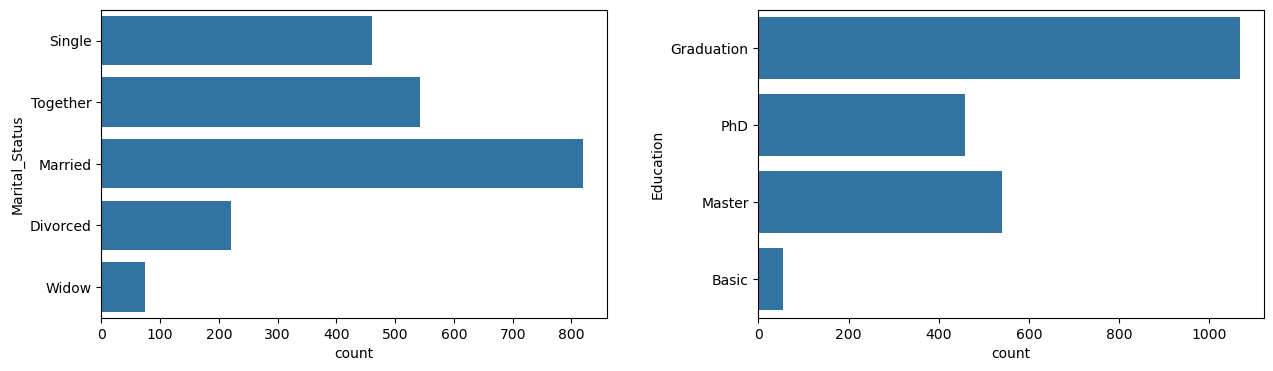

In [16]:
# Обновленные графики 

fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.countplot(df['Marital_Status'], ax=ax[0])
sns.countplot(df['Education'], ax=ax[1])

plt.subplots_adjust(wspace=0.3)
plt.show()

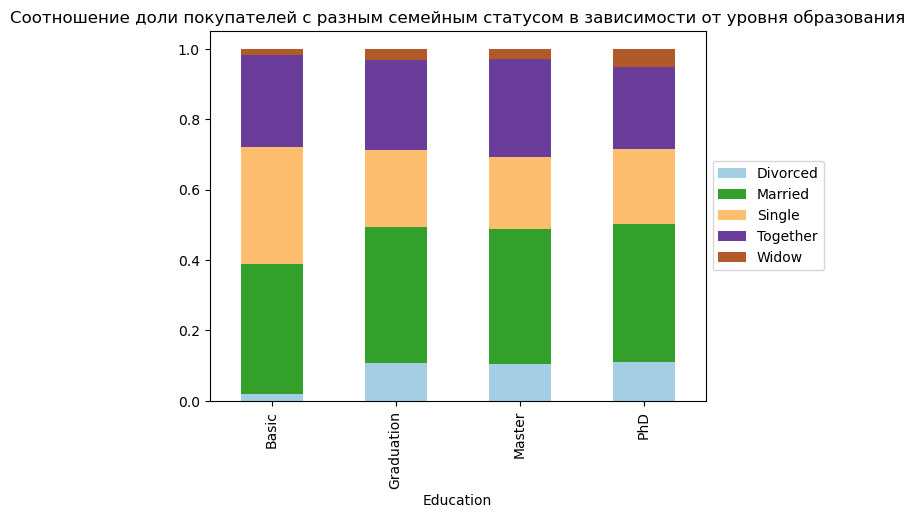

In [17]:
# Создание графика на основании сводной таблицы Уровень образования*Семейный статус

df_plot = df.groupby(['Marital_Status', 'Education']).size().reset_index().pivot(columns='Marital_Status', index='Education', values=0) # создание сводной табилцы для построения графика
df_plot.apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True,  colormap='Paired', title='Соотношение доли покупателей с разным семейным статусом в зависимости от уровня образования')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Исследовательские вопросы:

1. Какие рекламные компании получили больше одобрения?
2. Коррелируют ли количество откликов на рекламные компании с общими тратами в магазине и с доходом покупателей?
2. Коррелируют ли количество покупок сделанных со скидкой с общими тратами в магазине?
3. Каков общий доход магазина за приведенное время? Сколько в среднем потратим каждый покупатель за приведенное время?
3. Как распределяются траты покупателей между различными категориями продуктов?
4. Где совершается больше покупок: в физическом магазине или онлайн?
5. На какой площадке покуматели тратят больше денег: в физическом магазине или онлайн?


## Какие рекламные компании получили больше одобрения?

In [18]:
at_all = df['ID'].count()

Percent_Accepted = pd.DataFrame({'Compain': ['Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5', 'LasCmp'],
                                 'Percentage_of_acception': [df['AcceptedCmp1'].sum()/at_all*100, df['AcceptedCmp2'].sum()/at_all*100, df['AcceptedCmp3'].sum()/at_all*100, df['AcceptedCmp4'].sum()/at_all*100, df['AcceptedCmp5'].sum()/at_all*100, df['Response'].sum()/at_all*100]})
Percent_Accepted 

,Compain,Percentage_of_acception
0,Cmp1,6.562795
1,Cmp2,1.369216
2,Cmp3,7.554297
3,Cmp4,7.271010
4,Cmp5,7.554297
5,LasCmp,14.872521


### Вывод:

Наиболее удачной была последняя рекламная компания, получившая одобрение от 15% покупателей. Наименее удачной вторая, получившая всего 1%. Остальные компании имели примерно одинаковый уровень отклика - около 7%. 

Таким образом, последняя рекламная компания получила в два раза больше отклика, чем три предыдущие. 

## 

## Коррелируют ли количество откликов на рекламные компании с общими тратами в магазине и с доходом покупателей?
## Коррелируют ли количество покупок сделанных со скидкой с общими тратами в магазине?

Для начала построим хитмап для общей оценки связи между показателями

<Axes: >

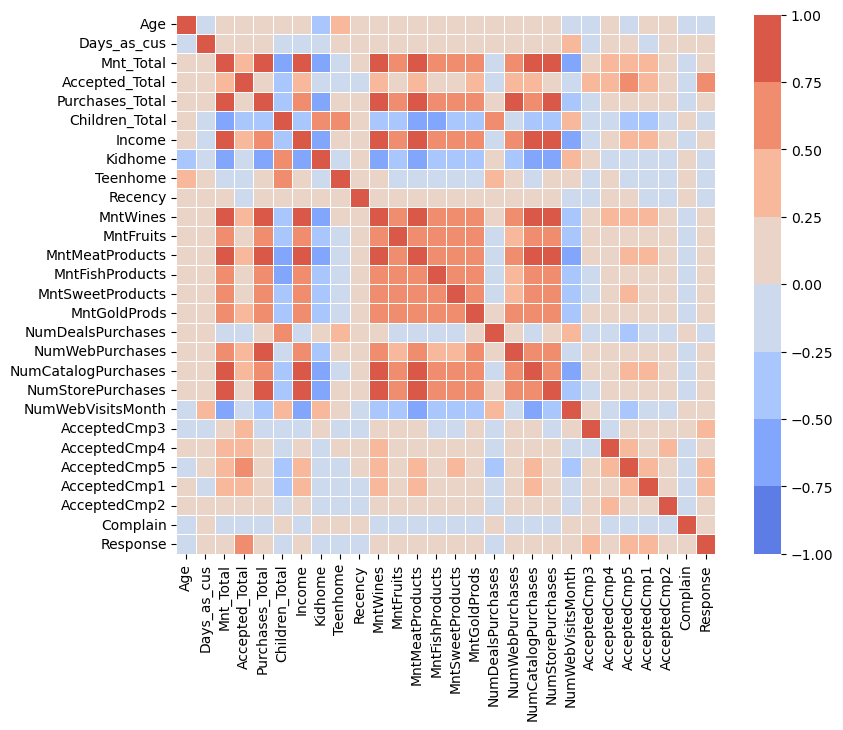

In [19]:
plt.figure(figsize=(10,7))

sns.heatmap(df.drop(['ID', 'Z_Revenue', 'Z_CostContact'], axis=1).corr(numeric_only=True, method='spearman'), 
            cmap=sns.color_palette("coolwarm", n_colors=8),
            vmin=-1,
            vmax=1, 
            square=True,
            linewidths=0.5
            )

Для ответа на вышеприведенные вопросы проведем корреляционный анализ с использованием критерия Спирмена

In [20]:
res1 = stats.spearmanr(df['Accepted_Total'], df['Mnt_Total'])
print(f'Взаимосвязь количества откликов на рекламные компании и общих трат покупателем\nКоэффициент r-Спирмена = {res1.statistic}\nУровень значимости = {res1.pvalue.round(3)}')

print()

res2 = stats.spearmanr(df['Accepted_Total'], df['Income'])
print(f'Взаимосвязь количества откликов на рекламные компании и дохода у покупателя\nКоэффициент r-Спирмена = {res2.statistic}\nУровень значимости = {res2.pvalue.round(3)}')

print()

res3 = stats.spearmanr(df['NumDealsPurchases'], df['Mnt_Total'])
print(f'Взаимосвязь количества покупок, сделанных со скидкой, и общих трат покупателей\nКоэффициент r-Спирмена = {res3.statistic}\nУровень значимости = {res3.pvalue.round(3)}')



Взаимосвязь количества откликов на рекламные компании и общих трат покупателем
Коэффициент r-Спирмена = 0.3840108251500316
Уровень значимости = 0.0

Взаимосвязь количества откликов на рекламные компании и дохода у покупателя
Коэффициент r-Спирмена = 0.32285395651911863
Уровень значимости = 0.0

Взаимосвязь количества покупок, сделанных со скидкой, и общих трат покупателей
Коэффициент r-Спирмена = -0.047166960823675726
Уровень значимости = 0.03


### Выводы: 

1. Количество откликов на рекламные компании положительно связано как с суммой общих трат покупателей, так и с их доходом на высоком уровне значимости (p<0.001). Однако связь эта относительно слабая и равна 0.4 и 0.3 соответственно. Тем не менее можно говорить о том, что чем чаще покупатель откликается на рекламные компании, тем большую сумму он тратит в магазине и тем выше его семейный доход. 

К сожалению, корреляционный анализ не позволяет нам судить о причино-следственных связях, поэтому ответ на вопрос о том, что за чем следует, остается открытым.

2. Количество покупок, сделанных со скидкой отрицательно связано с суммой общих трат в магазите. Хоть результат и является статистически значимым, но p-value равняется 0.03, что близко к 0.05 (пороговому показателю), а сила связи переменных по модулю равна 0,05. Таким образом, данную связь стоит рассматривать с остороностью.  

## 

## Каков общий доход магазина за приведенное время? 

## Сколько в среднем потратим каждый покупатель за приведенное время?

In [21]:
print(f'Общий доход магазина = {df['Mnt_Total'].sum()}$')
print()
print(f'В среднем каждый покупатель потратил примерно {df['Mnt_Total'].mean().round(2)}$')

Общий доход магазина = 1188623$

В среднем каждый покупатель потратил примерно 561.2$


## 

## Как распределяются траты покупателей между различными категориями продуктов?

Для сравнения средних трат на различные категории продуктов произведем рассчет критерия Краскела-Уоллиса, так как распределение суммы трат в группах не соответствует нормальному распределению (применение ANOVA невозможно)

In [22]:
res4 = stats.kruskal(df['MntFishProducts'], df['MntMeatProducts'], df['MntFruits'], df['MntSweetProducts'], df['MntWines'])
res4

KruskalResult(statistic=2728.8147458238623, pvalue=0.0)

Согласно результатам, средние траты на разные продукты отличаются среди групп. Для понимания, какие именно группы отличаются между собой, применим posthoc критерий Данна

In [23]:
p_values = sp.posthoc_dunn([df['MntFishProducts'], df['MntMeatProducts'], df['MntFruits'], df['MntSweetProducts'], df['MntWines']])
print(p_values <0.05)

       1      2      3      4      5
1  False   True   True   True   True
2   True  False   True   True   True
3   True   True  False  False   True
4   True   True  False  False   True
5   True   True   True   True  False


Все группы, кроме 3 и 4 (категории "фрукты" и "сладости") имеют статистически значимые различия. Построим столбчатую диаграмму средних значений затрат на эти категории продуктов

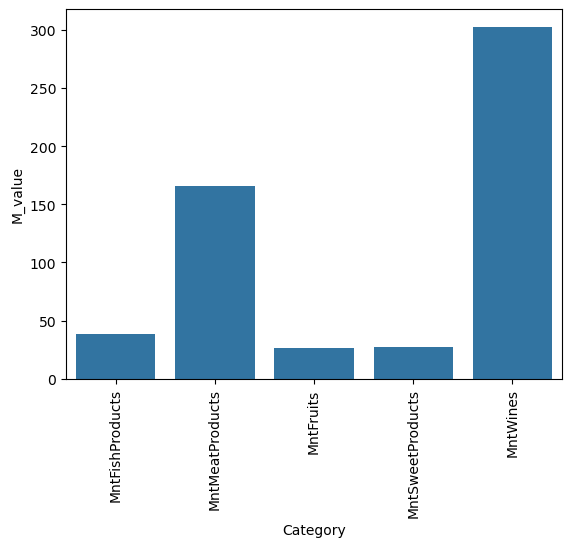

In [24]:
mean_values = pd.DataFrame({'Category': ['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntWines'],
                            'M_value': [df['MntFishProducts'].mean(), df['MntMeatProducts'].mean(), df['MntFruits'].mean(), df['MntSweetProducts'].mean(), df['MntWines'].mean()]})

sns.barplot(data=mean_values, x='Category', y='M_value')
plt.xticks(rotation=90)
plt.show()

Также построим круговую диаграмму на основе суммарного количества трат на каждую категорию продуктов

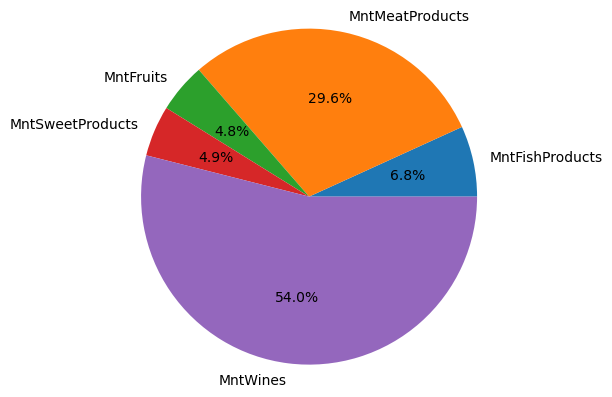

In [25]:
total_values = pd.DataFrame({'Category': ['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntWines'],
                            'Total_value': [df['MntFishProducts'].sum(), df['MntMeatProducts'].sum(), df['MntFruits'].sum(), df['MntSweetProducts'].sum(), df['MntWines'].sum()]})

plt.pie(total_values['Total_value'], labels=total_values['Category'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()
#sns.barplot(data=total_values, x='Category', y='Total_value')
#plt.xticks(rotation=90)

### Выводы: 
1. На покупку различных категорий товаров покупатели тратят статистически значимо разное количество средств. Исключением являются лишь категории фруктов и сладостей, которые между собой не имеют различий в тратах.
2. В среднем наибольшее количество средств тратится покупателями на приобретение винной продукции (~300$), практически в два раза превышая средние затраты на приобретение второй по величине затрат категории - мясной продукции (~170$). 
3. В абсолютных затратах также лидирует винная продукция, обеспечивая 54% выручки магазина.
4. Наименьшее количество средств покупатели тратят на сладости и фрукты - категории, вместе составляющиие 1/10 выручки магазина.


### 

## Где совершается больше покупок: в физическом магазине или онлайн?

Для выявнения ответа на этот вопрос проведем сравнительный анализ с использованием критерия U-Манна-Уитни

In [26]:
res5 = stats.mannwhitneyu(df['NumWebPurchases'], df['NumStorePurchases'])

print(f'Сравнение количества покупок сделанных в офлайн- и онлайн-магазине\nКоэффициент U-Манна-Уитни = {res5.statistic}\nУровень значимости = {res5.pvalue.round(3)}')
print()
print(f'Среднее количество покупок в онлайн-магазине = {df['NumWebPurchases'].mean().round(2)}\nСреднее количество покупок в офлайн-магазине = {df['NumStorePurchases'].mean().round(2)}')


Сравнение количества покупок сделанных в офлайн- и онлайн-магазине
Коэффициент U-Манна-Уитни = 1515070.0
Уровень значимости = 0.0

Среднее количество покупок в онлайн-магазине = 4.03
Среднее количество покупок в офлайн-магазине = 5.8


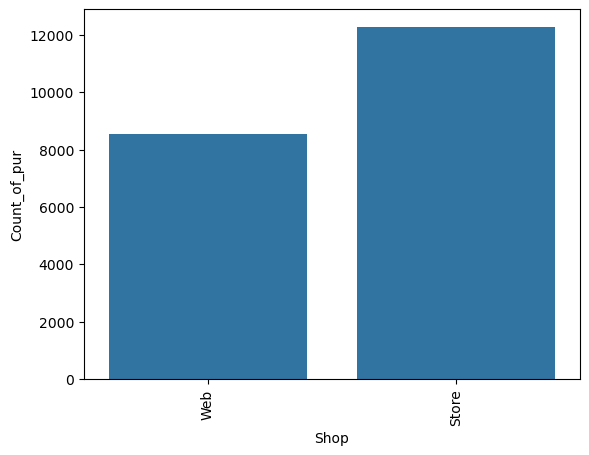

In [27]:
total_purchases = pd.DataFrame({'Shop': ['Web', 'Store'],
                               'Count_of_pur': [df['NumWebPurchases'].sum(), df['NumStorePurchases'].sum()]})

sns.barplot(data=total_purchases, x='Shop', y='Count_of_pur')
plt.xticks(rotation=90)
plt.show()

### Выводы: 

1. Между группами обнаружены статистически значимые различия, соответственно, покупок в офлайн магазине делается больше, чем на вебсайте
2. За время сбора имеющихся данных в физическом магазине было совершено более 12000 покупок, а онлайн - около 8500. Таким образом в офлайн-магазине совершается практически в 1,5 раза больше покупок.

## 

## На какой площадке покупатели тратят больше денег: в физическом магазине или онлайн?

К сожалению, на основании имеющихся данных узнать ответ на данный вопрос невозможно, так как мы не имеем информации и том, сколько с общем каждый покупатель тратил в каждом из магазинов. 

Однако можно сделать грубую косвенную оценку доходности от магазинов посредством разделения покупателей на две группы: тех, кто делал больше покупок онлайн, и тех, кто делал больше покупок офлайн. 

In [28]:
res6 = stats.mannwhitneyu(df['Mnt_Total'][df['NumWebPurchases'] < df['NumStorePurchases']], df['Mnt_Total'][df['NumWebPurchases'] > df['NumStorePurchases']])

print(f'Сравнение общих затрат покупателей в зависимости от того, в каком магазине они совершали больше покупок: офлайн и онлайн\nКоэффициент U-Манна-Уитни = {res6.statistic}\nУровень значимости = {res6.pvalue.round(3)}')
print()
print(f'Средние затраты покупателей, совершивших больше покупок на вебсайте = {df['Mnt_Total'][df['NumWebPurchases'] > df['NumStorePurchases']].mean().round(2)}\nСредние затраты покупателей, совершивших больше покупок в физическом магазине = {df['Mnt_Total'][df['NumWebPurchases'] < df['NumStorePurchases']].mean().round(2)}')


Сравнение общих затрат покупателей в зависимости от того, в каком магазине они совершали больше покупок: офлайн и онлайн
Коэффициент U-Манна-Уитни = 191186.5
Уровень значимости = 0.0

Средние затраты покупателей, совершивших больше покупок на вебсайте = 678.83
Средние затраты покупателей, совершивших больше покупок в физическом магазине = 551.55


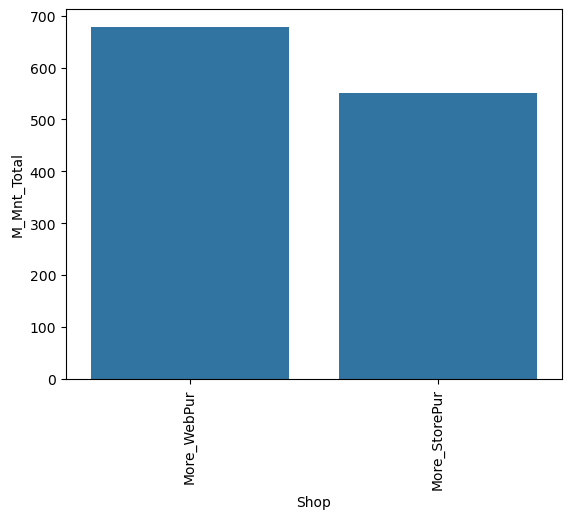

In [29]:
total_amount = pd.DataFrame({'Shop': ['More_WebPur', 'More_StorePur'],
                      'M_Mnt_Total': [df['Mnt_Total'][df['NumWebPurchases'] > df['NumStorePurchases']].mean(), df['Mnt_Total'][df['NumWebPurchases'] < df['NumStorePurchases']].mean()]})

sns.barplot(data=total_amount, x='Shop', y='M_Mnt_Total')
plt.xticks(rotation=90)
plt.show()

Таким образом, в среднем покупатели, совершаюшие покупки онлайн в среднем тратят 679$, что статистически значимо больше затрат покупателей, закупающиеся преимущественно в офлайн-магазинах (552$).

Построим диаграмму суммарных трат покупателей внутри этих двух групп.

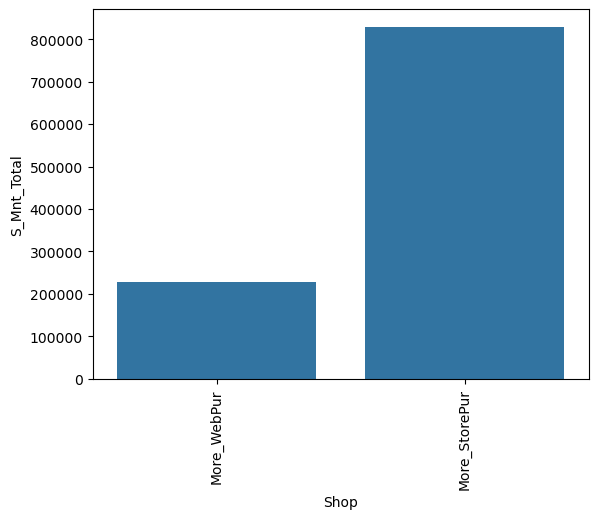

In [30]:
total_amount = pd.DataFrame({'Shop': ['More_WebPur', 'More_StorePur'],
                      'S_Mnt_Total': [df['Mnt_Total'][df['NumWebPurchases'] > df['NumStorePurchases']].sum(), df['Mnt_Total'][df['NumWebPurchases'] < df['NumStorePurchases']].sum()]})

sns.barplot(data=total_amount, x='Shop', y='S_Mnt_Total')
plt.xticks(rotation=90)
plt.show()

При суммировании общих затрат получается, что покупатели, совершающие больше покупок в офлайн-магазине, тратят значительно больше, чем покупатели заказывающие товары онлайн. 

Возможно, это связано с распределением покупателей по показателю общих трат внутри каждой из групп. Для выяснения построим гистограммы.

<Axes: >

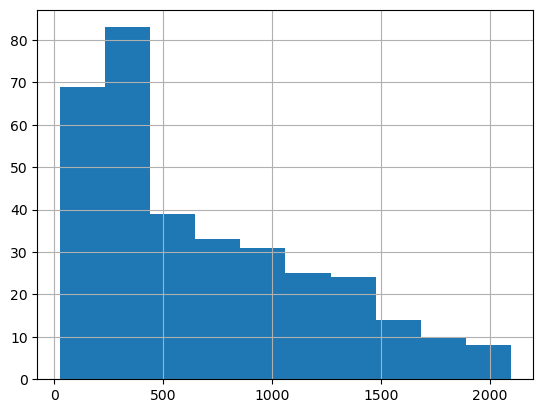

In [31]:
df['Mnt_Total'][df['NumWebPurchases'] > df['NumStorePurchases']].hist()

<Axes: >

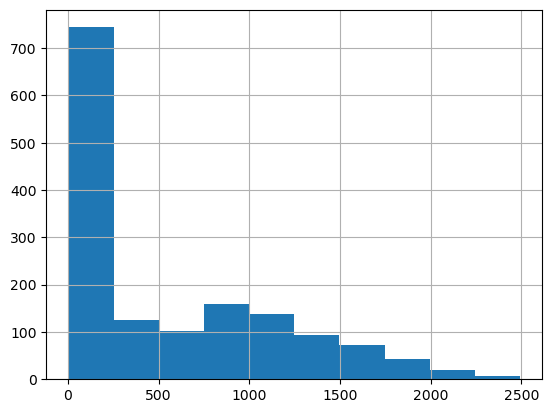

In [32]:
df['Mnt_Total'][df['NumWebPurchases'] < df['NumStorePurchases']].hist()

### Выводы:
1. Действительно, из графиков видно, что среди покупателей, закупающихся преимущественно офлайн, присутствует много лиц, имеющих очень маленькие затраты (<250$), что влияет на величину среднего арифметического значения (средних затрат), уменьшая его.
2. Тем не менее, это не исключает того факта, что суммарные общие затраты больше именно у покупателей, совершающих больше офлайн-покупок.
